# 🧙‍♂️ Sample Generation with Pretrained Model + LLLA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_llla_flow.ipynb)

### Initial setup ⚙️

### If runned locally

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [2]:
# !pip install laplace-torch

In [3]:
if IN_COLAB:
    import os
    !pip install laplace-torch -q 
    repo_dir = "PML_DL_Final_Project"
    
    if not os.path.exists(repo_dir):
        !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
    else:
        print(f"Repository '{repo_dir}' already exists. Skipping clone.")

        
    if os.path.isdir(repo_dir):
        %cd $repo_dir
        !pip install dotenv -q
    else:
        print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

else:
    %cd ..

/Users/jaczac/Github/PML_DL_Final_Project


### 📦 Imports

In [4]:
import torch

from PIL import Image
from src.models.flow import UQFlowMatching
from src.utils.data import get_llla_dataloader
from src.utils.plots import plot_image_uncertainty_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model
import os

/Users/jaczac/Github/PML_DL_Final_Project/src/models/flow.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 🧪 Setup: Seed and Device

In [5]:
seed = 1337
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [6]:
sample_batch_size = 16
save_dir = "samples"
model_name = "unet"
method = "flow"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

#### Define Class for QUDiffusion

### 💪 Fit Laplace approximation

In [14]:
from src.models.llla_model import LaplaceApproxModel
from types import SimpleNamespace

num_classes = 10
model_kwargs={
    "num_classes": num_classes, "time_emb_dim": 128,
    # NOTE: We are currently using different time embedding because of a small bug but it is fine
    "time_embedding_type": "mlp" if method == "flow" else "sinusoidal"
}

# Load pretrained MAP model using best checkpoint
flow_model = load_pretrained_model(
    model_name="unet",
    # ckpt_path="jac-zac/diffusion-project/best-model:v91",
    ckpt_path="jac-zac/diffusion-project/best-model:v83",
    device=device,
    model_kwargs=model_kwargs,
    use_wandb=True,
)


# Prepare data loaders for the Laplace fit
train_loader, _ = get_llla_dataloader(batch_size=sample_batch_size, mode = "flow")

mnist_config = SimpleNamespace()
mnist_config.data = SimpleNamespace()
mnist_config.data.image_size = 28  # MNIST image size

# Wrap diffusion model with your Custom Model for Laplace last layer approx
# NOTE: Automatically call fit
laplace_model = LaplaceApproxModel(
    flow_model, train_loader, args=None, config=mnist_config
)

print("Laplace fitting completed on last layer of the diffusion model.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /Users/jaczac/.config/netrc/netrc
wandb:   1 of 1 files downloaded.  


Fitting Laplace:   0%|          | 0/3750 [00:00<?, ?it/s]

Laplace fitting completed on last layer of the diffusion model.


<!-- #region id="1d2b6a2d" -->
### 💨 Initialize Flow Process

In [19]:
# NOTE: total steps and num intermediate have to match in this flow matching implementation

total_steps = 20
num_intermediate = 15
n_samples = 8

# Initialize uncertainty-aware diffusion (same interface as base class)
flow = UQFlowMatching(img_size=mnist_config.data.image_size, device=device)

# NOTE: If we prouce multiple images then the scale is the same for all of them and it doesn't show well
all_samples_grouped, uncertainties = plot_image_uncertainty_grid(
        model=laplace_model,
        method_instance=flow,
        num_intermediate=num_intermediate,
        n=n_samples,
        total_steps=total_steps,
        save_dir=save_dir,
        device=device,
        num_classes=num_classes,
        cov_num_sample=100,
        uq_cmp = "viridis",
        # uq_cmp = "grey",
    )

"""
# Get full sample and uncertainty tensors
step_indices = torch.linspace(0, total_steps - 1, steps=num_intermediate, dtype=torch.int32).tolist()

all_samples_grouped, uncertainties = flow.sample_with_uncertainty(
    model=laplace_model,
    log_intermediate=True,
    t_sample_times=step_indices,
    y=torch.arange(n_samples, device=device) % num_classes,
    cov_num_sample=100,
    num_steps=total_steps,
)
"""

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

'\n# Get full sample and uncertainty tensors\nstep_indices = torch.linspace(0, total_steps - 1, steps=num_intermediate, dtype=torch.int32).tolist()\n\nall_samples_grouped, uncertainties = flow.sample_with_uncertainty(\n    model=laplace_model,\n    log_intermediate=True,\n    t_sample_times=step_indices,\n    y=torch.arange(n_samples, device=device) % num_classes,\n    cov_num_sample=100,\n    num_steps=total_steps,\n)\n'

In [16]:
"""
save_path = os.path.join(save_dir, "selected_uncertainties.png")
plot_selected_uncertainties(
    uncertainties=uncertainties,
    save_path=save_path,
    timesteps=step_indices,
    selected_indices=list(range(0,num_intermediate,2)),  # Pick any 5 timesteps
    uq_cmp="viridis"
)

# Display uncertainties grid
out_path_unc = os.path.join(save_dir, "selected_uncertainties.png")
display(Image.open(out_path_unc))
"""

'\nsave_path = os.path.join(save_dir, "selected_uncertainties.png")\nplot_selected_uncertainties(\n    uncertainties=uncertainties,\n    save_path=save_path,\n    timesteps=step_indices,\n    selected_indices=list(range(0,num_intermediate,2)),  # Pick any 5 timesteps\n    uq_cmp="viridis"\n)\n\n# Display uncertainties grid\nout_path_unc = os.path.join(save_dir, "selected_uncertainties.png")\ndisplay(Image.open(out_path_unc))\n'

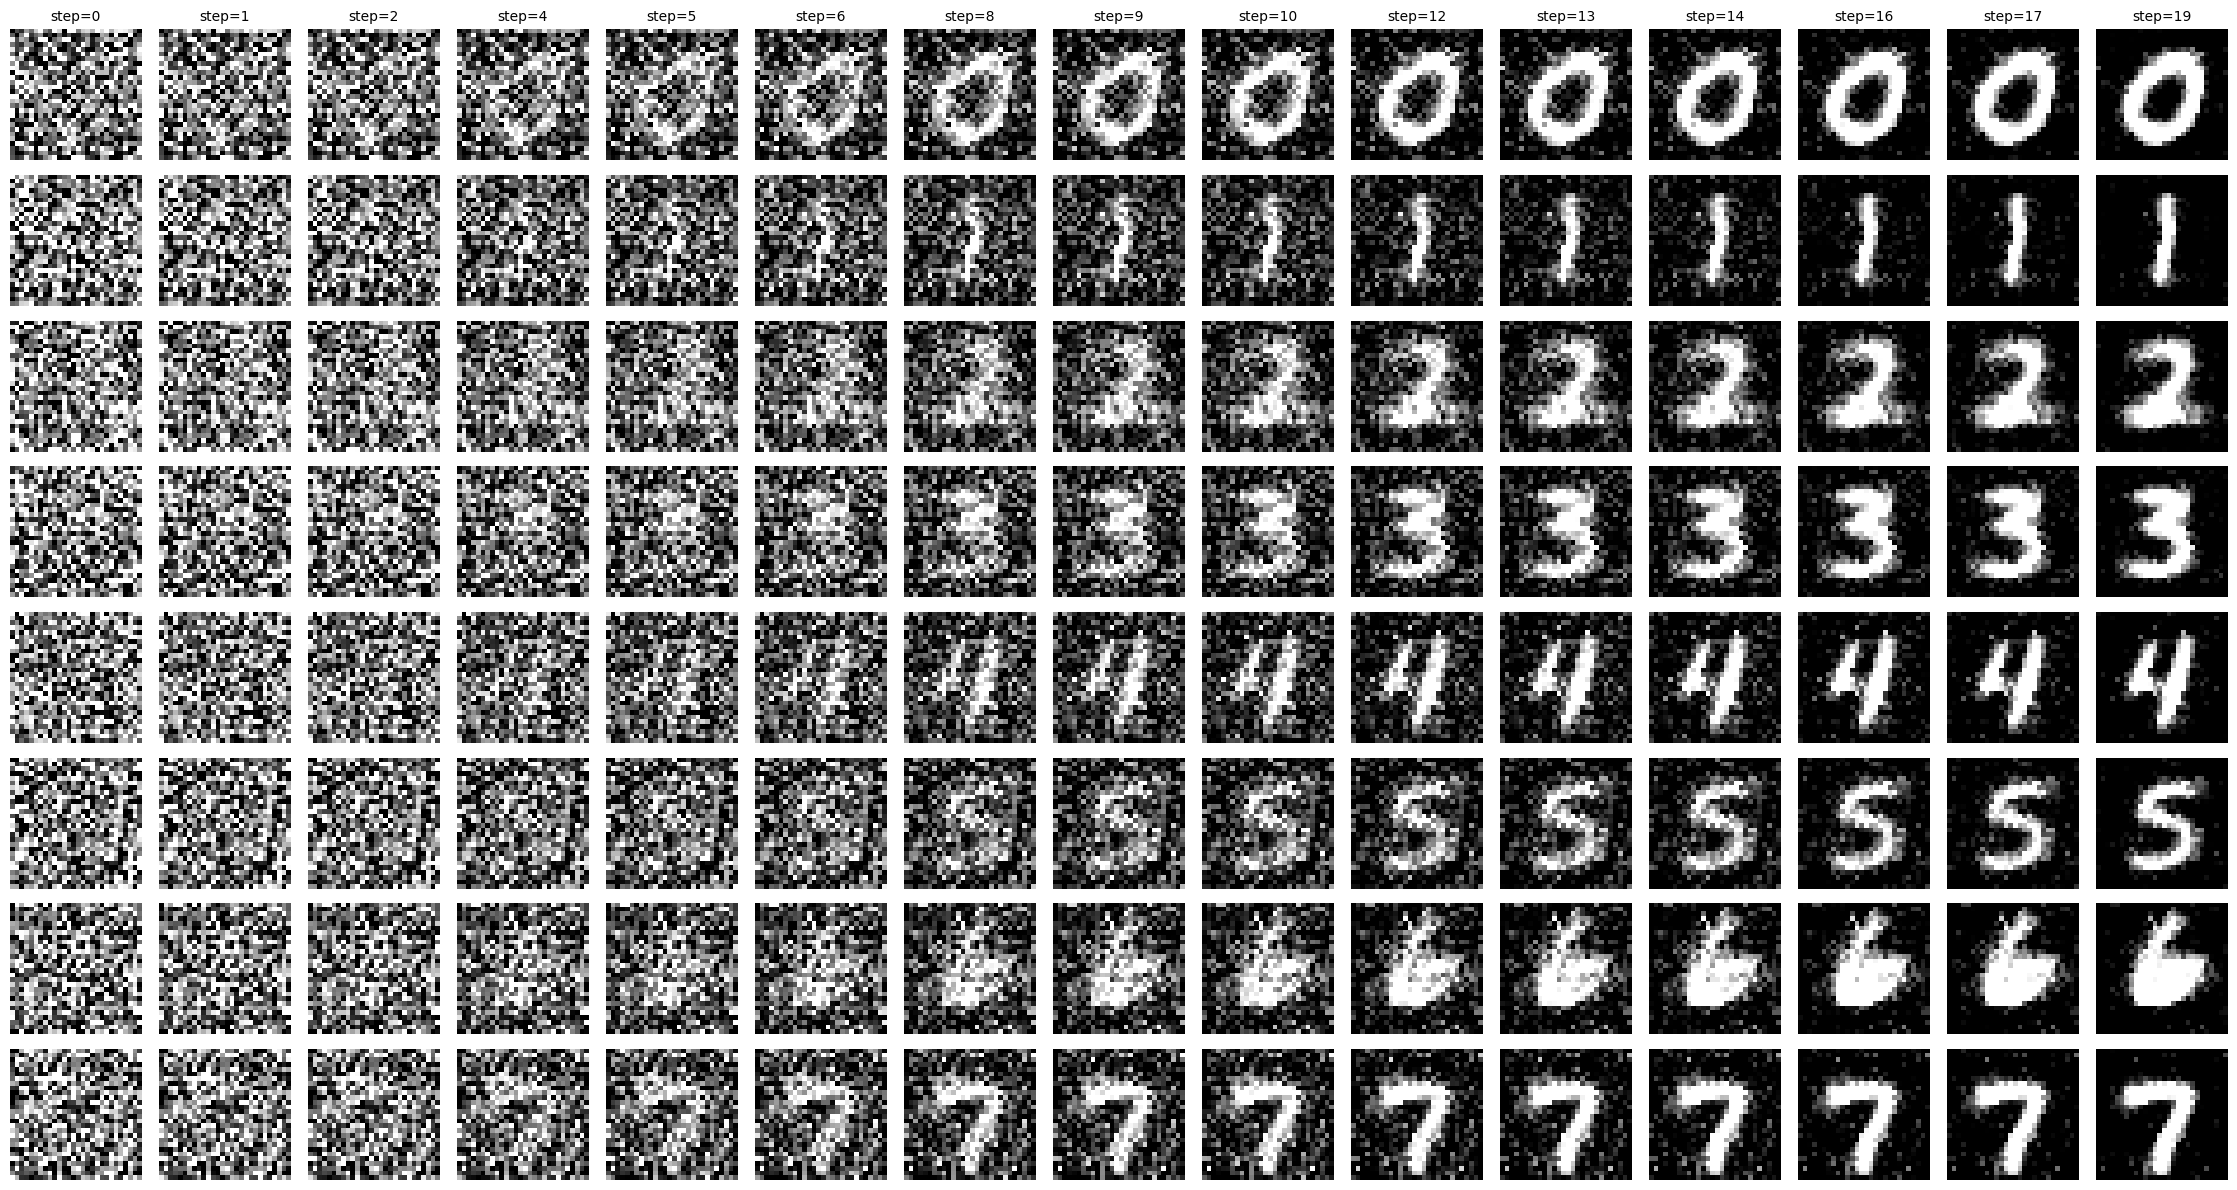

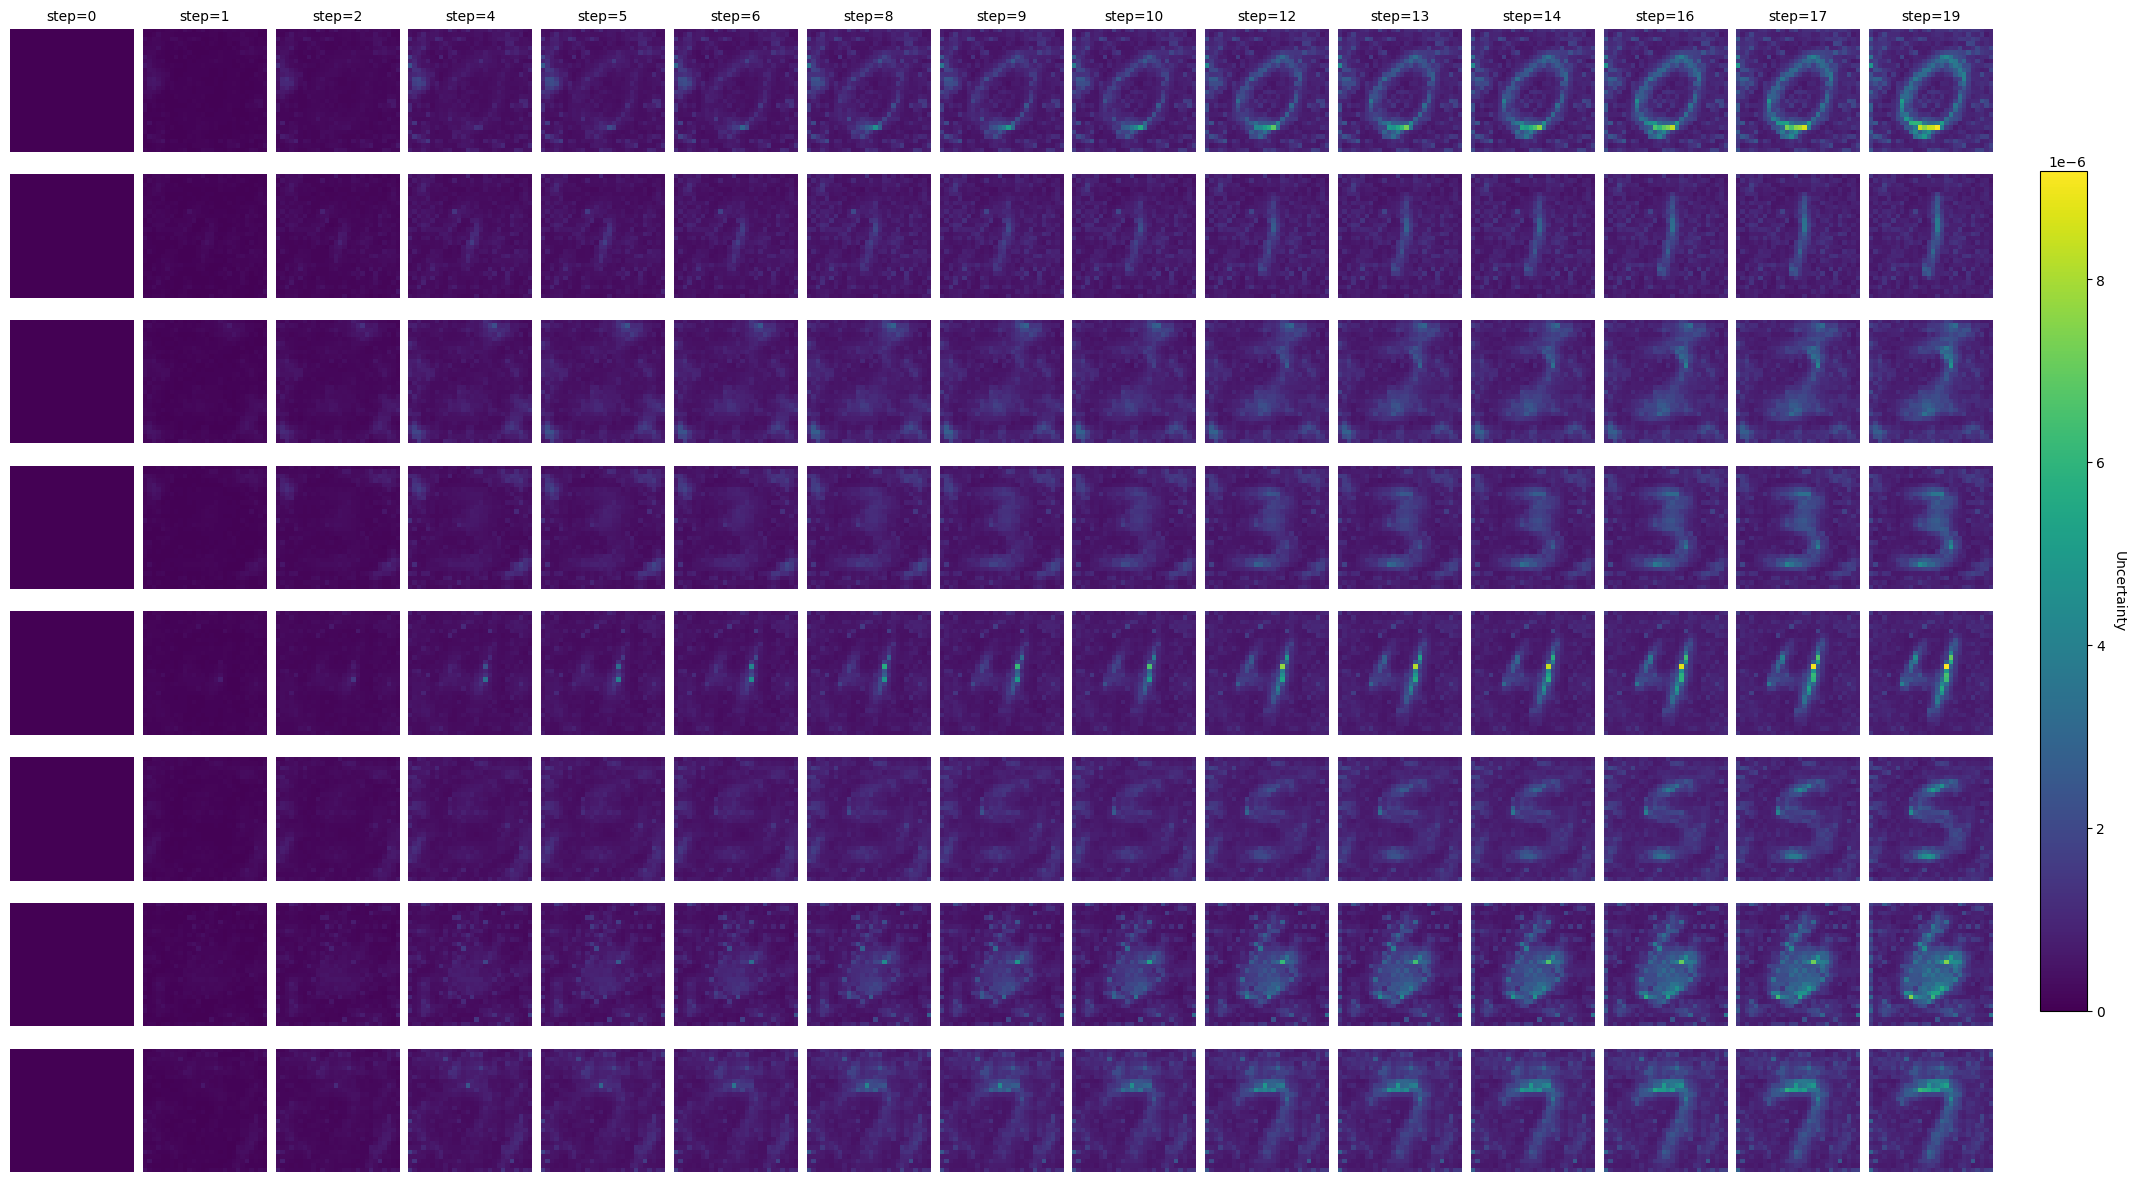

In [20]:
# Display samples grid
out_path_img = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path_img))

# Display uncertainties grid
out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")
display(Image.open(out_path_unc))

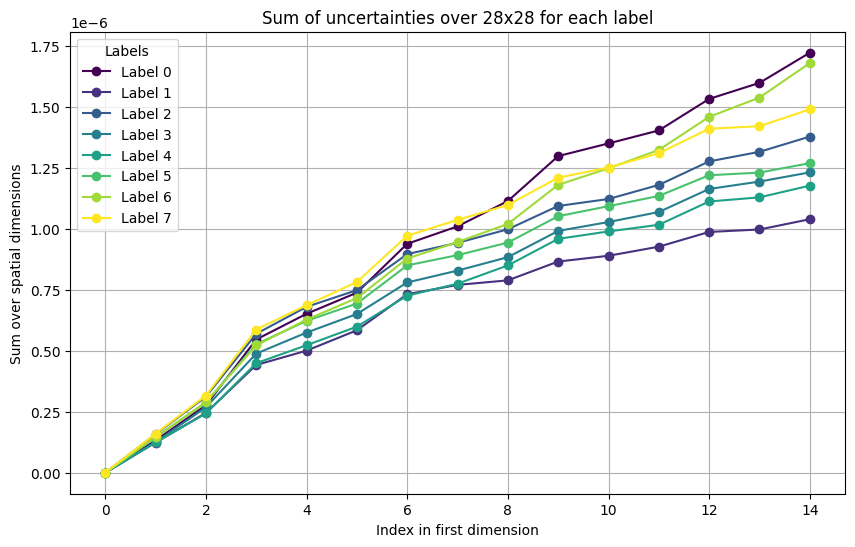

In [21]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# Assuming uncertainties shape: [num_intermediate, num_labels, height, width]
num_intermediate = uncertainties.shape[0]
num_labels = uncertainties.shape[1]

# Define a colormap with enough distinct colors for each label
cmap = plt.get_cmap("viridis", num_labels)

plt.figure(figsize=(10, 6))

for label_idx in range(num_labels):
    # Sum over the last two dimensions (height and width) for each label
    sums = uncertainties[:, label_idx].sum(dim=[-1, -2])  # shape: [num_intermediate]
    
    # Convert sums to a numpy array if needed (e.g., if using PyTorch)
    if hasattr(sums, 'cpu'):
        sums = sums.cpu().numpy()
    
    # Plot with a distinct color for each label
    plt.plot(range(num_intermediate), sums, marker='o', linestyle='-', color=cmap(label_idx), label=f"Label {label_idx}")

plt.title("Sum of uncertainties over 28x28 for each label")
plt.xlabel("Index in first dimension")
plt.ylabel("Sum over spatial dimensions")
plt.grid(True)
plt.legend(title="Labels")
plt.show()